In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfd = tfp.distributions

seaborn.set()
tf.random.set_seed(50)

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
%load_ext tensorboard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [4]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Set the State Space Model

In [5]:
tf.random.set_seed(0)
observation_dim = 2
state_dim = 2
T = 500
initial_state          = tf.random.uniform([state_dim], -1., 1.)

transition_matrix      = tf.eye(state_dim) * 0.5
transition_covariance  = tf.eye(state_dim) * 0.5

chol_transition_covariance = tf.linalg.cholesky(transition_covariance)

observation_matrix     = tf.eye(observation_dim) * 0.5
observation_covariance = tf.eye(observation_dim) * 0.1

chol_observation_covariance = tf.linalg.cholesky(observation_covariance)

In [6]:
# Transition
zeros = tf.zeros(state_dim, dtype=float)

transition_noise = tfd.MultivariateNormalTriL(zeros, chol_transition_covariance)
transition_model = RandomWalkModel(transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(zeros, chol_observation_covariance)
observation_model = LinearObservationSampler(observation_matrix, observation_error)

In [9]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
states, observations = ss_model(initial_state, T)

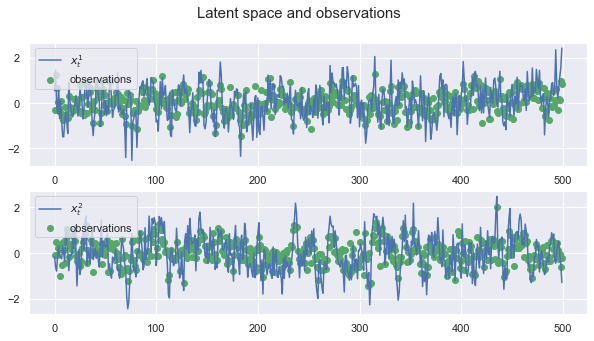

In [10]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [11]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)

### Set up the filter

In [12]:
# store observations
batch_size = 1
n_particles = 100
dimension = 2

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods)


In [13]:
init_transition_matrix = tf.random.uniform([state_dim, state_dim], 0., 1.)
learnable_transition_matrix = tf.Variable(init_transition_matrix, trainable=True)

init_triangular_covariance = tfp.math.fill_triangular(tf.random.uniform([state_dim*(state_dim+1)//2], -1., 1.))
learnable_transition_covariance = tf.Variable(init_triangular_covariance, trainable=True)

In [14]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()

epsilon = tf.constant(0.25)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)
solver = RicattiSolver(0.2, 10., 1e-3)
corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4, ricatti_solver=solver, propagate_correction_gradient=False)

zeros = tf.zeros(state_dim, dtype=float)
learnable_transition_noise = tfd.MultivariateNormalTriL(loc=zeros, scale_tril=learnable_transition_covariance)
learnable_transition_model = RandomWalkModel(learnable_transition_matrix, learnable_transition_noise)

proposal_model = BootstrapProposalModel(learnable_transition_model)
    
learnable_systematic_smc = SMC(observation_model, learnable_transition_model, proposal_model, resampling_criterion, systematic)
learnable_regularized_smc = SMC(observation_model, learnable_transition_model, proposal_model, resampling_criterion, regularized)
learnable_corrected_smc = SMC(observation_model, learnable_transition_model, proposal_model, resampling_criterion, corrected)
true_smc = SMC(observation_model, transition_model, proposal_model, resampling_criterion, systematic)

In [17]:
new_state = proposal_model.propose(initial_state, None, None)

In [19]:
proposal_model.loglikelihood(initial_state, new_state, None, None)

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.692332  , -3.8786747 , -5.1297226 , -1.9471698 , -1.8046601 ,
        -0.65224683, -0.9008925 , -1.0997016 , -1.9490492 , -1.4002182 ,
        -3.4562557 , -1.7650244 , -3.2379549 , -1.3330896 , -0.9188187 ,
        -0.976495  , -1.1229944 , -2.0463712 , -5.6496315 , -2.4513671 ,
        -2.2965286 , -3.5642154 , -2.7522094 , -1.6331298 , -2.8654168 ,
        -0.75095224, -3.590031  , -3.5677726 , -0.59956884, -3.5482976 ,
        -1.0283806 , -1.9081204 , -0.601418  , -5.1691656 , -1.4831862 ,
        -2.580161  , -0.9574487 , -0.77418566, -3.0325425 , -1.9718711 ,
        -1.2876456 , -1.4379408 , -1.2333908 , -1.6293094 , -3.0568302 ,
        -3.4244196 , -1.423465  , -1.0973904 , -1.6048045 , -2.2047539 ,
        -0.85596704, -0.6928339 , -2.1384933 , -0.79359984, -1.0506408 ,
        -1.7977111 , -2.6677175 , -1.6140571 , -5.099745  , -1.5744312 ,
        -1.587908  , -1.98734   , -3.661904  , -0.73904085, -2.254394  ,
 

In [14]:
# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.05)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [15]:
@tf.function
def loss_func(smc):
    tf.random.set_seed(75)
    final_state = smc(initial_state, observation_series=obs_data, n_observations=T, return_final=True)
    return -tf.reduce_mean(final_state.log_likelihoods), tf.math.reduce_std(final_state.log_likelihoods)

In [16]:
@tf.function
def train_one_step(optimizer, smc):
    var_list= [learnable_transition_matrix, learnable_transition_covariance]
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        loss, _ = loss_func(smc)
    grads = tape.gradient(loss, var_list)
    clip = lambda val: tf.clip_by_value(val, -100., 100.)
    grads = [clip(grad) for grad in grads]
    optimizer.apply_gradients(zip(grads,var_list))
    return loss, grads

@tf.function
def train(optimizer, smc, num_steps = 101):
    assign_1 = learnable_transition_matrix.assign(init_transition_matrix)
    assign_2 = learnable_transition_covariance.assign(init_triangular_covariance)
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies([assign_1, assign_2]):
        for step in tf.range(num_steps):
            loss, grads = train_one_step(optimizer, smc)
            tf.print('Step', step, '/', num_steps - 1, ': loss = ', loss, end='\r')
            #tf.print('grads', grads, end='\r')
            
            loss_tensor_array = loss_tensor_array.write(step, loss)
            grad_tensor_array = grad_tensor_array.write(step, tf.reduce_max(tf.abs(grads)))
    return loss_tensor_array.stack(), grad_tensor_array.stack(), tf.convert_to_tensor(learnable_transition_matrix), tf.convert_to_tensor(learnable_transition_covariance @ tf.transpose(learnable_transition_covariance))
            

In [17]:
sys_loss, sys_grad, sys_learned_transition_matrix, sys_learned_covariance = train(optimizer, 
                                                                                  learnable_systematic_smc, 
                                                                                  num_steps=101)

In [18]:
print('\n Transition Matrix: ')
print(sys_learned_transition_matrix)


print('\n Transition Covariance: ')
print(sys_learned_covariance)


 Transition Matrix: 
tf.Tensor(
[[0.53021574 0.02240285]
 [0.02210229 0.57728213]], shape=(2, 2), dtype=float32)

 Transition Covariance: 
tf.Tensor(
[[0.44823438 0.00381063]
 [0.00381063 0.41103196]], shape=(2, 2), dtype=float32)


In [ ]:
reg_loss, reg_grad, reg_learned_transition_matrix, reg_learned_covariance = train(optimizer, 
                                                                                  learnable_regularized_smc, 
                                                                                  num_steps=501)

In [ ]:
print('\n Transition Matrix: ')
print(reg_learned_transition_matrix)


print('\n Transition Covariance: ')
print(reg_learned_covariance)

# Check with pykalman

In [ ]:
import pykalman
kf = pykalman.KalmanFilter(transition_matrix.numpy(), 
                           observation_matrix.numpy(), 
                           transition_covariance.numpy(), 
                           observation_covariance.numpy(), 
                           initial_state_mean=[0., 0.], 
                           initial_state_covariance= np.eye(2))

In [ ]:
em_kf = kf.em(np_obs, n_iter = 50, em_vars=['transition_covariance', 'transition_matrices'])

In [ ]:

print('\n Observation Matrix: ')
print(em_kf.observation_matrices)


print('\n Transition Matrix: ')
print(em_kf.transition_matrices)


print('\n Observation Covariance: ')
print(em_kf.observation_covariance)


print('\n Transition Covariance: ')
print(em_kf.transition_covariance)